In [ ]:
!pip -q install transformers datasets evaluate accelerate sentencepiece rouge-score matplotlib pandas numpy torch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.9 MB/s eta 0:00:00


In [ ]:
import time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from datasets import load_dataset
import evaluate
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

rouge= evaluate.load("rouge")

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def generate_summary(model, tokenizer, text, device, max_input_len=512, max_new_tokens=80):
    inputs= tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_input_len
    ).to(device)

    with torch.no_grad():
        output_ids= model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=4,
            early_stopping=True
        )

    summary= tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return summary

def topsis(decision_matrix, weights, impacts):
    X= np.array(decision_matrix, dtype=float)

    denom= np.sqrt((X ** 2).sum(axis=0))
    denom[denom == 0]= 1.0
    R= X / denom

    W= np.array(weights, dtype=float)
    W= W / W.sum()
    V= R * W

    impacts_arr= np.array([1 if imp == "+" else -1 for imp in impacts])

    ideal_best= np.zeros(V.shape[1])
    ideal_worst= np.zeros(V.shape[1])

    for j in range(V.shape[1]):
        if impacts_arr[j] == 1:
            ideal_best[j]= V[:, j].max()
            ideal_worst[j]= V[:, j].min()
        else:
            ideal_best[j]= V[:, j].min()
            ideal_worst[j]= V[:, j].max()

    dist_best= np.sqrt(((V - ideal_best) ** 2).sum(axis=1))
    dist_worst= np.sqrt(((V - ideal_worst) ** 2).sum(axis=1))

    score= dist_worst / (dist_best + dist_worst + 1e-12)
    ranks= score.argsort()[::-1] + 1
    return score, ranks

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
device= "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

dataset_name= "xsum"
sample_n= 50

data= load_dataset(dataset_name, split="test").select(range(sample_n))
print("Loaded:", dataset_name, "Samples:", len(data))

models_to_test= [
    "facebook/bart-large-cnn",
    "sshleifer/distilbart-cnn-12-6",
    "t5-base",
    "google/pegasus-xsum"
]

Device: cuda


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/300M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/16.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

Loaded: xsum Samples: 50


In [ ]:
results = []

for model_name in models_to_test:
    print("\n==============================")
    print("Testing model:", model_name)

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
    model.eval()

    params = count_parameters(model)
    params_million = params / 1e6

    preds = []
    refs = []
    times = []

    for i in range(len(data)):
        text = data[i]["document"]
        reference = data[i]["summary"]

        if device == "cuda":
            torch.cuda.synchronize()
        start = time.time()

        pred = generate_summary(model, tokenizer, text, device=device)

        if device == "cuda":
            torch.cuda.synchronize()
        end = time.time()

        preds.append(pred)
        refs.append(reference)
        times.append(end - start)

        if (i + 1) % 10 == 0:
            print("Done", i + 1, "/", len(data))

    rouge_scores = rouge.compute(predictions=preds, references=refs)

    avg_time = float(np.mean(times))
    r1 = float(rouge_scores["rouge1"])
    r2 = float(rouge_scores["rouge2"])
    rL = float(rouge_scores["rougeL"])

    row = {
        "Model": model_name,
        "ROUGE-1": r1,
        "ROUGE-2": r2,
        "ROUGE-L": rL,
        "AvgTimeSec": avg_time,
        "Params(M)": params_million
    }
    results.append(row)

    # Free memory between models
    del model, tokenizer
    if device == "cuda":
        torch.cuda.empty_cache()

df = pd.DataFrame(results)
df


Testing model: facebook/bart-large-cnn


config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Please make sure the generation config includes `forced_bos_token_id=0`. 


Loading weights:   0%|          | 0/511 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Done 10 / 50
Done 20 / 50
Done 30 / 50
Done 40 / 50
Done 50 / 50

Testing model: sshleifer/distilbart-cnn-12-6


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/358 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Done 10 / 50
Done 20 / 50
Done 30 / 50
Done 40 / 50
Done 50 / 50

Testing model: t5-base


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/257 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Done 10 / 50
Done 20 / 50
Done 30 / 50
Done 40 / 50
Done 50 / 50

Testing model: google/pegasus-xsum


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/680 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
PegasusForConditionalGeneration LOAD REPORT from: google/pegasus-xsum
Key                                  | Status  | 
-------------------------------------+---------+-
model.encoder.embed_positions.weight | MISSING | 
model.decoder.embed_positions.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

Done 10 / 50
Done 20 / 50
Done 30 / 50
Done 40 / 50
Done 50 / 50


,Model,ROUGE-1,ROUGE-2,ROUGE-L,AvgTimeSec,Params(M)
0,facebook/bart-large-cnn,0.192064,0.034457,0.122344,1.124447,406.290432
1,sshleifer/distilbart-cnn-12-6,0.198941,0.037150,0.131349,0.830280,408.451072
2,t5-base,0.200376,0.032140,0.140647,1.366267,222.903552
3,google/pegasus-xsum,0.475365,0.263926,0.401561,0.593371,766.567424


In [ ]:
import numpy as np
import pandas as pd

# df is already loaded from csv (your current df)
criteria_cols = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "AvgTimeSec", "Params(M)"]

weights = [3, 4, 3, 2, 1]
impacts = ["+", "+", "+", "-", "-"]

def topsis(decision_matrix, weights, impacts):
    X = np.array(decision_matrix, dtype=float)

    denom = np.sqrt((X ** 2).sum(axis=0))
    denom[denom == 0] = 1.0
    R = X / denom

    W = np.array(weights, dtype=float)
    W = W / W.sum()
    V = R * W

    ideal_best = np.zeros(V.shape[1])
    ideal_worst = np.zeros(V.shape[1])

    for j in range(V.shape[1]):
        if impacts[j] == "+":
            ideal_best[j] = V[:, j].max()
            ideal_worst[j] = V[:, j].min()
        else:
            ideal_best[j] = V[:, j].min()
            ideal_worst[j] = V[:, j].max()

    dist_best = np.sqrt(((V - ideal_best) ** 2).sum(axis=1))
    dist_worst = np.sqrt(((V - ideal_worst) ** 2).sum(axis=1))

    score = dist_worst / (dist_best + dist_worst + 1e-12)
    ranks = (-score).argsort().argsort() + 1
    return score, ranks

decision_matrix = df[criteria_cols].values.tolist()
scores, ranks = topsis(decision_matrix, weights, impacts)

df["TOPSIS_Score"] = scores
df["Rank"] = ranks

df = df.sort_values("Rank").reset_index(drop=True)
df

,Model,ROUGE-1,ROUGE-2,ROUGE-L,AvgTimeSec,Params(M),TOPSIS_Score,Rank
0,google/pegasus-xsum,0.475365,0.263926,0.401561,0.593371,766.567424,0.883985,1
1,sshleifer/distilbart-cnn-12-6,0.198941,0.037150,0.131349,0.830280,408.451072,0.137615,2
2,t5-base,0.200376,0.032140,0.140647,1.366267,222.903552,0.120281,3
3,facebook/bart-large-cnn,0.192064,0.034457,0.122344,1.124447,406.290432,0.095356,4


In [ ]:
df.to_csv("topsis_summarization_results.csv", index=False)
print("Updated CSV saved with TOPSIS_Score and Rank")

Updated CSV saved with TOPSIS_Score and Rank


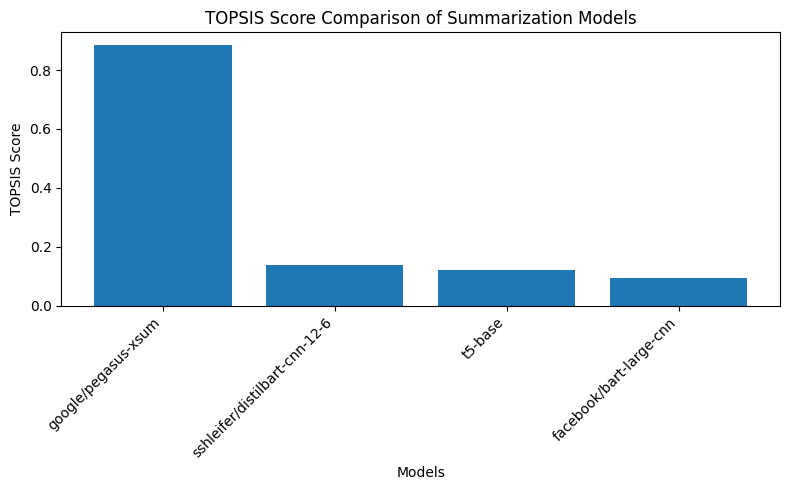

Saved: topsis_scores_bar.png


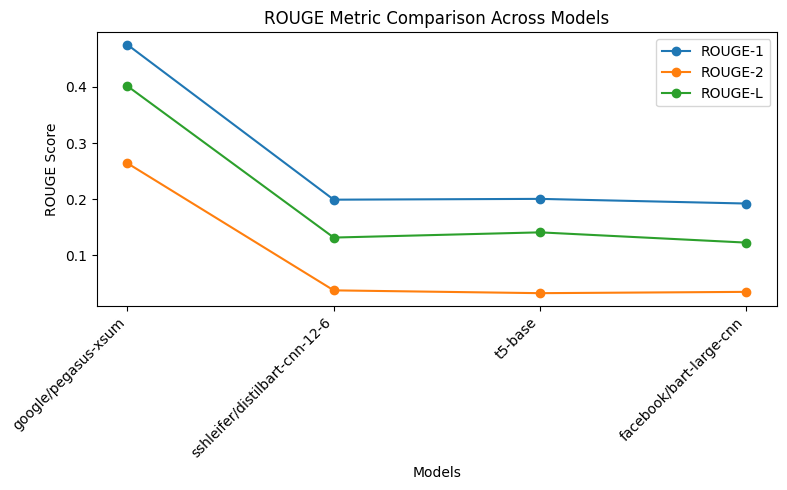

Saved: rouge_metrics_line.png


In [ ]:
import matplotlib.pyplot as plt

# 1) TOPSIS Score bar graph
plt.figure(figsize=(8,5))
plt.bar(df["Model"], df["TOPSIS_Score"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Models")
plt.ylabel("TOPSIS Score")
plt.title("TOPSIS Score Comparison of Summarization Models")
plt.tight_layout()
plt.savefig("topsis_scores_bar.png", dpi=300)
plt.show()

print("Saved: topsis_scores_bar.png")

# 2) ROUGE metrics line graph
plt.figure(figsize=(8,5))
plt.plot(df["Model"], df["ROUGE-1"], marker="o", label="ROUGE-1")
plt.plot(df["Model"], df["ROUGE-2"], marker="o", label="ROUGE-2")
plt.plot(df["Model"], df["ROUGE-L"], marker="o", label="ROUGE-L")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Models")
plt.ylabel("ROUGE Score")
plt.title("ROUGE Metric Comparison Across Models")
plt.legend()
plt.tight_layout()
plt.savefig("rouge_metrics_line.png", dpi=300)
plt.show()

print("Saved: rouge_metrics_line.png")

In [ ]:
from google.colab import files

files.download("topsis_summarization_results.csv")
files.download("topsis_scores_bar.png")
files.download("rouge_metrics_line.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
print([f for f in os.listdir() if f.endswith(".ipynb")])

[]
